<h1>Abgabe</h1>

In [1]:
!pip install yfinance
!pip install pandas


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Aktie herunterladen
stock_symbol = "AAPL"
start_date = "2010-01-01"
end_date = datetime.now().strftime('%Y-%m-%d')

stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
print(stock_data.head())


[*********************100%%**********************]  1 of 1 completed

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.461976  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.473148  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.370184  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.358409  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.400681  447610800


In [3]:
# Datenbereinigung
stock_data = stock_data.dropna().copy()  # Entfernen fehlender Werte und Kopie erstellen
print(stock_data.isna().sum())  # Überprüfen auf fehlende Werte


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [4]:
def HMA(data, window):
    half_length = int(window / 2)
    sqrt_length = int(np.sqrt(window))
    WMA_half = data['Close'].rolling(window=half_length).apply(lambda x: np.dot(x, np.arange(1, half_length + 1)) / np.sum(np.arange(1, half_length + 1)), raw=True)
    WMA_full = data['Close'].rolling(window=window).apply(lambda x: np.dot(x, np.arange(1, window + 1)) / np.sum(np.arange(1, window + 1)), raw=True)
    raw_HMA = 2 * WMA_half - WMA_full
    HMA = raw_HMA.rolling(window=sqrt_length).apply(lambda x: np.dot(x, np.arange(1, sqrt_length + 1)) / np.sum(np.arange(1, sqrt_length + 1)), raw=True)
    return HMA

def calculate_moving_averages(data):
    data = data.copy()  # Sicherstellen, dass wir mit einer Kopie arbeiten
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
    data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()
    data['HMA_20'] = HMA(data, 20)
    data['HMA_50'] = HMA(data, 50)
    return data

stock_data = calculate_moving_averages(stock_data)


In [5]:
# Zeitrahmen definieren
end_train_date = datetime.now() - timedelta(days=365)
start_train_date = "2010-01-01"  # Anfang des Zeitraums, ab dem wir trainieren

# Trainingsdaten
train_data = stock_data[(stock_data.index >= start_train_date) & (stock_data.index < end_train_date.strftime('%Y-%m-%d'))].copy()

# Testdaten
start_test_date = end_train_date + timedelta(days=1)
end_test_date = datetime.now()
test_data = stock_data[(stock_data.index >= start_test_date.strftime('%Y-%m-%d')) & (stock_data.index <= end_test_date.strftime('%Y-%m-%d'))].copy()

print(f"Trainingsdaten von {start_train_date} bis {end_train_date.strftime('%Y-%m-%d')}")
print(f"Testdaten von {start_test_date.strftime('%Y-%m-%d')} bis {end_test_date.strftime('%Y-%m-%d')}")


Trainingsdaten von 2010-01-01 bis 2023-08-13
Testdaten von 2023-08-14 bis 2024-08-12


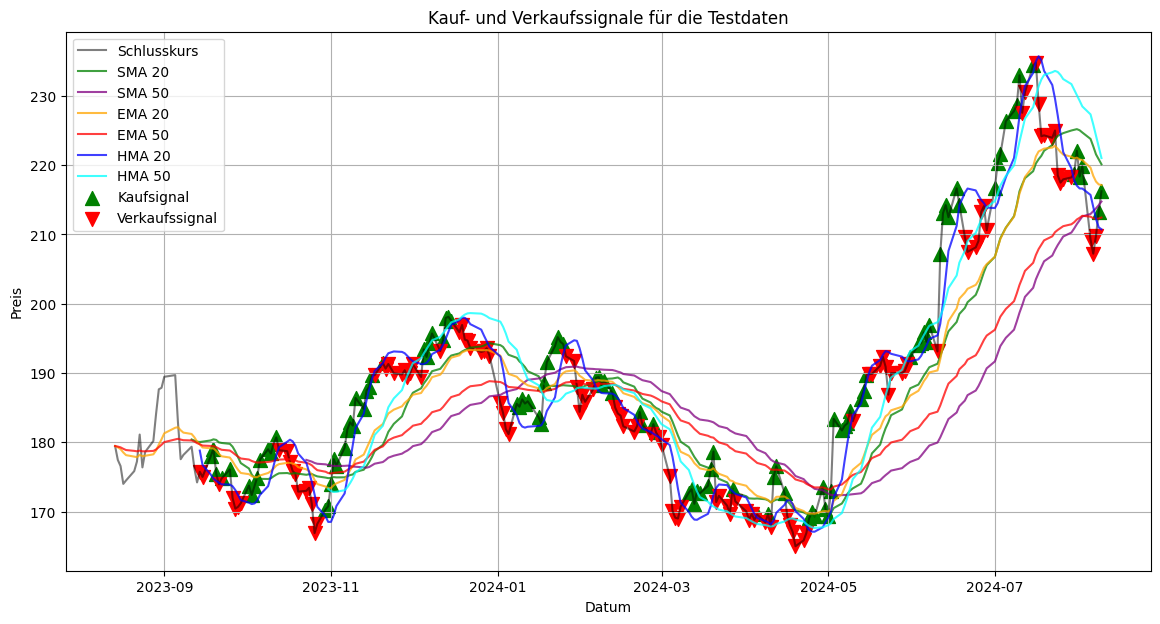

In [7]:
def generate_signals(data):
    data = data.copy()  # Sicherstellen, dass wir mit einer Kopie arbeiten
    data['Signal'] = 0
    # Kauf- und Verkaufssignale basierend auf HMA
    buy_signal_condition = (data['Close'] > data['HMA_20'])
    sell_signal_condition = (data['Close'] < data['HMA_20'])
    data.loc[buy_signal_condition, 'Signal'] = 1
    data.loc[sell_signal_condition, 'Signal'] = -1
    return data

# Berechnung und Signalgenerierung
train_data = calculate_moving_averages(train_data)
train_data = generate_signals(train_data)
test_data = calculate_moving_averages(test_data)
test_data = generate_signals(test_data)

def plot_signals(data, title):
    plt.figure(figsize=(14, 7))
    plt.plot(data.index, data['Close'], label='Schlusskurs', color='black', alpha=0.5)
    plt.plot(data.index, data['SMA_20'], label='SMA 20', color='green', alpha=0.75)
    plt.plot(data.index, data['SMA_50'], label='SMA 50', color='purple', alpha=0.75)
    plt.plot(data.index, data['EMA_20'], label='EMA 20', color='orange', alpha=0.75)
    plt.plot(data.index, data['EMA_50'], label='EMA 50', color='red', alpha=0.75)
    plt.plot(data.index, data['HMA_20'], label='HMA 20', color='blue', alpha=0.75)
    plt.plot(data.index, data['HMA_50'], label='HMA 50', color='cyan', alpha=0.75)
    plt.scatter(data.index[data['Signal'] == 1], data['Close'][data['Signal'] == 1], marker='^', color='green', s=100, label='Kaufsignal')
    plt.scatter(data.index[data['Signal'] == -1], data['Close'][data['Signal'] == -1], marker='v', color='red', s=100, label='Verkaufssignal')
    plt.title(title)
    plt.xlabel('Datum')
    plt.ylabel('Preis')
    plt.legend()
    plt.grid()
    plt.show()

# Plotten der Signale für Testdaten
plot_signals(test_data, 'Kauf- und Verkaufssignale für die Testdaten')
